# Example workflow using ANUGA unstructured grid
### Kyle Wright and Jay Hariharan, July 2020

This workbook provides an example workflow for running particles on an unstructured model output (i.e. flow variables are from a non-Cartesian grid). We make use of several of the geospatial functions in `particle_track.py` and others in `routines.py`, in order to show how to grid hydrodynamic input files, convert UTM coordinates into (and out of) the array coordinates used in routing the particles, as well as how to compute exposure times to a region of interest. Hopefully this example in conjunction with other examples can provide information on how users can adapt these codes to their use-case.

To demonstrate this functionality, we make use of outputs from the hydrodynamic model ANUGA (github.com/GeoscienceAustralia/anuga_core/), which solves the 2D shallow-water equations on a triangular mesh. We've extracted outputs from a previous example model run and included these as text files in the repository, so as to avoid importing any dependencies not required by this distribution. If the user is also using ANUGA flow-fields, there is a a commented-out block of code below demonstrating how we extracted the input files for use in this workbook. 

### Import necessary dependencies

In [1]:
import numpy as np
import scipy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import json
import particlerouting
from particlerouting import particle_track as pt
from particlerouting import routines


### Load in model outputs

If we were starting directly from an ANUGA output file, this is where we would import the outputs from the model run. We have included these files directly with the distribution, but for anyone interested in repeating the steps we used to generate these files, uncomment the block of code below.

Here, `path2file` should point to the ANUGA output file (e.g. `./model_output.sww`). This output is a NetCDF file with flow variables (e.g. `depth`, `xmom`, `stage`) listed by triangle index, along with the centroid coordinates (`x`, `y`) of that triangle. In our case, those coordinates are in meters UTM, which will be relevant later.

In [2]:
# # Import anuga to access functions (NOTE: Anuga requires Python 2.7!)
# import anuga

# # Folder name of run to analyze:
# path2file = 'examples/example_model.sww'

# # Extract the files from NetCDF using Anuga's `get_centroids` function:
# swwvals = anuga.utilities.plot_utils.get_centroids(path2file, timeSlices = 'last')
# # Query values: time, x, y, stage, elev, height, xmom, ymom, xvel, yvel, friction, vel, etc

# # Here, since we are only interested in saving variables, we migrate variables to a dictionary:
# # Make sure to filter out NaN's before converting to lists, if there are any
# unstructured = dict()
# unstructured['x'] = swwvals.x.tolist()
# unstructured['y'] = swwvals.y.tolist()
# unstructured['depth'] = swwvals.height[0].tolist()
# unstructured['stage'] = swwvals.stage[0].tolist()
# unstructured['qx'] = swwvals.xmom[0].tolist()
# unstructured['qy'] = swwvals.ymom[0].tolist()

# # And then we save this dictionary into a json (text) file for later import
# json.dump(unstructured, open('unstructured_model.txt', 'w'))
# # This generates the file imported in this workbook

Here, we will skip the above step and just import the `unstructured_model.txt` dictionary.

**Note**: We have chosen to save/import the variables `depth`, `stage`, `qx`, and `qy` in this application. However, we could have chosen to save and use the fields `topography`, `u`, and `v` (or in ANUGA's terminology, `elev`, `xvel`, and `yvel`). The particle tracking code accepts any of these inputs, as long as you provide enough information to calculate the water surface slope, depth of the water column, and the two components of inertia. 

In [3]:
unstructured = json.load(open('unstructured_model.txt'))

### Convert data and coordinates for particle routing

Now that we have the data we need, we can convert it into the format needed by `particlerouting`. This will include gridding the hydrodynamic outputs and transforming our geospatial coordinates into "array index" coordinates.

First, let's combine our $(x,y)$ coordinates into a list of tuples. This is the expected format for coordinates in the following functions. 

In [4]:
# Use list comprehension to convert into tuples
coordinates = [(unstructured['x'][i], unstructured['y'][i]) for i in list(range(len(unstructured['x'])))]

# Let's see the extent of our domain
print(min(unstructured['x']), max(unstructured['x']), 
      min(unstructured['y']), max(unstructured['y']))
# As well as our number of data points
print(len(unstructured['x']))

(624422.25, 625031.9375, 3346870.0, 3347107.75)
103558


Now, let's grid our unstructured data into a uniform grid. For this, we make use of the function `particle_track.unstruct2grid()`, which uses inverse-distance-weighted interpolation to create a Cartesian grid the same size as our model's extent. To use this function, we need to provide:
- Our list of `coordinates` (as tuples).
- The unstructured data we want to be gridded (here we start with `depth`).
- The desired grid size of the resulting rasters (here we're using $1 m$, because the test model was on very high-resolution lidar data).
- The number of $k$ nearest neighbors to use in the interpolation. If $k=1$, we use only the nearest datapoint, whereas higher values (default is $k=3$) interpolate the data into a smoother result.

The underlying code relies on `scipy` to build a `cKDTree` of our unstructured data, which maps the datapoints onto a uniform array. `cKDTree` is much faster than other gridding functions (e.g. `scipy.interpolate.griddata`), but building the tree can still be very slow if the dataset is very large or if the desired grid size is very small.  

The outputs of `unstruct2grid` are:
- The resulting interpolation function `myInterp` (after building the nearest-distance tree), which will be considerably faster than calling `unstruct2grid` again if we are gridding additional datasets. This function assumes data have the same coordinates, grid size, and $k$.
- A gridded array of our data.

Text(0.5,1,'Gridded Depth Array')

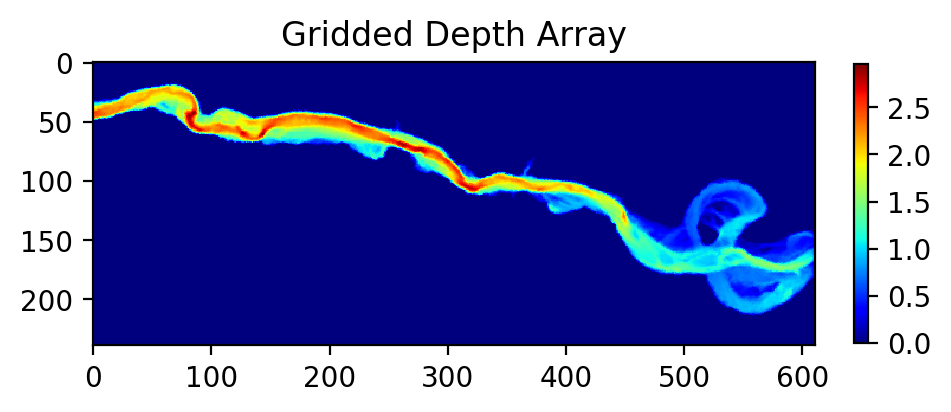

In [5]:
# Use IDW interpolation interpolate unstructured data into uniform grid
myInterp, depth = pt.unstruct2grid(coordinates, unstructured['depth'], 1.0, 3)

# Let's plot the resulting grid to see what the output looks like:
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(depth, cmap='jet')
plt.colorbar(fraction=0.018)
plt.title('Gridded Depth Array')

Now, let's use the new function `myInterp` to grid our additional datasets. If `unstruct2grid` took a while to grid the first dataset, this function will be considerably faster than re-running that process, because it re-uses most of the results of that first function call. This function only requires as input the new unstructured data to be gridded. 

All of these variables will have the same grid size as the first dataset, and we assume that they have all the same coordinates. 

Text(0.5,1,'Gridded Y-Discharge Array')

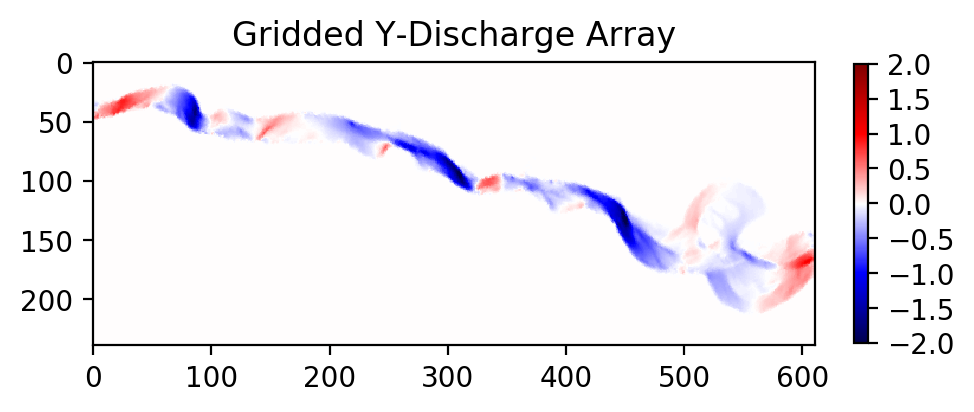

In [6]:
# Grid other data products with new interpolation function
stage = myInterp(np.array(unstructured['stage']))
qx = myInterp(np.array(unstructured['qx']))
qy = myInterp(np.array(unstructured['qy']))
# Should be very fast compared to the first dataset!

# Let's plot one of these variables to see the new grid
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(qy, vmin=-2, vmax=2, cmap='seismic')
plt.colorbar(fraction=0.018)
plt.title('Gridded Y-Discharge Array')

**Note:** In all these cases, if your unstructured data does not fill the full rectangular domain, IDW interpolation may still populate those exterior regions with data. If this has potential to cause problems when routing particles, make sure to do some pre-processing on these rasters to correct those exterior regions or crop the domain. 

Now, let's figure out where we want to seed our particles. If you're modeling a real domain, it may be easier to figure out a good release location by opening some GIS software and finding the coordinates of that location. Here, we will use the function `particle_track.coord2ind()` to convert your coordinates into array indices. This function requires:
- Coordinates to be converted, as a list [] of $(x,y)$ tuples
- The location of the lower left corner of your rasters (i.e. the origin). If you used `unstruct2grid` to generate rasters, this location will be `[(min(x), min(y))]`. Otherwise, if you're loading data from e.g. a GeoTIFF, the lower left corner will be stored in the .tif metadata and can be accessed by GIS software or gdalinfo (if the user has GDAL)
- The dimensions of the raster, accessible via `np.shape(raster)`
- The grid size of the raster (here $1m$)

**Note:** this coordinate transform flips the orientation of the unit vectors (i.e. $y_{index} = x$ and $x_{index} = -y$) as well as returning raster indices. This is convenient for the internal functions of `particle_tools.py`, but may cause confusion with plotting or interpreting later if locations are not translated back into spatial coordinates. (Don't worry, we will convert back later!)

We assume in all of these functions that the coordinates you're using are (at least locally) flat. We do not account for the curvature of the Earth in very large domains. Hopefully you are using a projected coordinate system (here we are using meters UTM), or at least willing to accept a little distortion. Note that this `coord2ind` requires units of either meters or decimal degrees. 

[(31, 42)]


(101, 1)

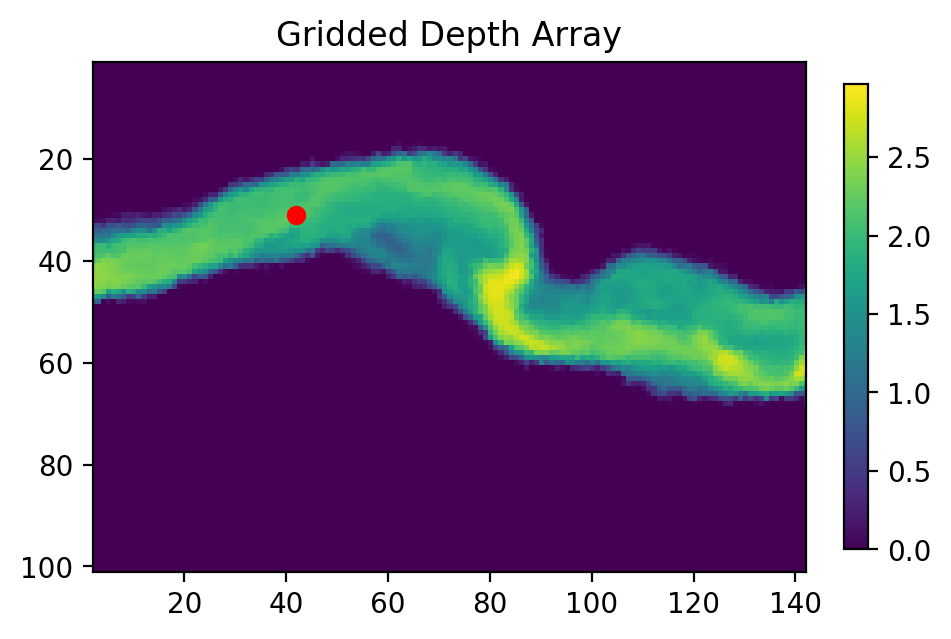

In [7]:
# I have found a nice release location in GIS. Let's convert it to index notation:
seedloc = [(624464, 3347078)] # Coordinates are in meters UTM

# Call the coordinate transform function
seedind = pt.coord2ind(seedloc, 
                       (min(unstructured['x']), 
                        min(unstructured['y'])), 
                       np.shape(depth), 1.0)
print(seedind)

# Visualize the location on our array
plt.figure(figsize=(5,5), dpi=200)
plt.scatter(seedind[0][1], seedind[0][0], c='r')
plt.imshow(depth)
plt.colorbar(fraction=0.03)
plt.title('Gridded Depth Array')
plt.xlim([seedind[0][1]-40, seedind[0][1]+100])
plt.ylim([seedind[0][0]+70, seedind[0][0]-30])

### Set up particle routing parameters

Now that we have pre-converted the input data we need, let's set up the particle routing to be run. We do this using the `particle_track.params` class, in which we populate the attributes to suit our application. This includes the gridded hydrodynamic outputs from above, the seed location, and other features of our particle application (e.g. grid size `dx`, number of particles `Np_tracer`, coefficients of the random walk).

In [8]:
# Create the parameters object and then assign the values
params = pt.params()

# Populate the params variables
params.stage = stage
params.depth = depth
params.qx = qx
params.qy = qy

# Now we in the region +/- 1 cell of the seed location we computed earlier
# Note that "xloc" and "yloc" are x and y in the particle coordinate system!
params.seed_xloc = [seedind[0][0]-1, seedind[0][0]+1]
params.seed_yloc = [seedind[0][1]-1, seedind[0][1]+1]

# For this example, we model 50 particles:
params.Np_tracer = 50

# Other choices/parameters
params.dx = 1. # Grid size
params.dry_depth = 0.01 # 1 cm considered dry
# You can also tell it which model you're using, but this only matters if the answer is DeltaRCM:
params.model = 'Anuga'

In this application, we are using the default values for the parameters of the random walk (`gamma`, `theta`, `diff_coeff`). I encourage you to play with these weights and see how your solution is affected. 

### Run the particle routing

Now we call on one of the routines, `routines.steady_plots()`, to run the model. The core of the particle routing occurs in the `particle_track.run_iteration()` function, but for ease of use, we have provided several high-level wrappers for the underlying code in the `routines.py` script. These routines take common settings, run the particle routing, and save a variety of plots and data for visualization. 

Because our model is a steady case (i.e. flow-field is not varying with time), `steady_plots` will run the particles for an equal number of iterations and return the travel history to us in the `walk_data` dict. This dict is organized into `['xinds']`, `['yinds']`, and `['travel_times']`, which are then indexed by particle ID, and then finally iteration number. (e.g. `walk_data['xinds'][5][10]` will return the xindex for the 6th particle's 11th iteration)

In [9]:
# Using steady (time-invariant) plotting routine for 200 iterations
walk_data = routines.steady_plots(params, 200, 'unstructured_grid_anuga')
# Outputs will be saved in the folder 'unstructured_grid_anuga'

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Theta parameter not specified - using 1.0
Gamma parameter not specified - using 0.05
Diffusion coefficient not specified - using 0.2
Cell Types not specified - Estimating from depth
Using weighted random walk
Directories already exist


100%|################################################################################| 200/200 [01:43<00:00,  1.94it/s]


Because the particles take different travel paths, at any given iteration they are *not guaranteed* to be synced up in time. We can check this using the `routines.get_state()` function, which allows us to slice the `walk_data` dictionary along a given iteration number. This function logically indexes the dict like `walk_data[:][:][iteration]`, except not quite as simple given the indexing rules of a nested list. 

By default, this function will return the most recent step (iteration number `-1`), but we could ask it to slice along any given iteration number. 

In [10]:
xi, yi, ti = routines.get_state(walk_data)
print(ti)

[265.49809934928425, 274.94251871162766, 284.81791839897977, 284.5477688667267, 303.1864479200722, 298.17222516065874, 272.6641530423291, 266.0862922952372, 351.373734333658, 283.77793522819405, 305.6739768877436, 307.37347412453516, 371.9278370985112, 354.82431957686254, 274.83774102910223, 323.1084291243818, 327.3923736890329, 291.32472310706464, 260.03387904829134, 332.5389772183608, 346.10742004405, 273.1838317620726, 288.9886334582885, 283.6613461994197, 275.01792816811127, 340.2764338509763, 276.49122325099637, 283.4006343397997, 320.0327248967139, 368.1455263315037, 262.17217679821584, 302.1498741709681, 291.35649376381184, 328.709884075514, 280.5716490424755, 290.9019072706647, 285.83270848854556, 287.6384125389391, 274.56682899570814, 282.5740608216943, 306.0197251195993, 341.50433755374485, 298.0967320335991, 285.78904850300944, 289.2900736094099, 281.92565769484133, 314.956172125463, 278.5259141919523, 282.39506170534554, 330.3238018528977]


**Note:** There exists an equivalent function, `get_time_state()`, which performs a similar function by slicing `walk_data` along a given travel time, in case there is interest in viewing the particles in sync. 

As a brief aside, the particle routing can also be run in an *unsteady* way, in which each particle continues taking steps until each has reached a specified `target_time`. This can be useful if you want to visualize particle travel times in "real time", or if you want to sync up their propagation with an unsteady flow field that updates every so often (e.g. every 30 minutes). This can be done either with the `unsteady_plots()` routine, or by interacting with `run_iteration()` directly. The commented-out block of code below shows an example of what an unsteady case might look like had we used more timesteps from the model output.

In [11]:
# # Specify folder to save figures:
# path2folder = 'place_to_save_figures'

# # Let's say our model outputs update every hour:
# model_timestep = 3600. # Units in seconds
# # Number of steps to take in total:
# num_steps = 24 # Run for one day
# # Create vector of target times
# target_times = np.arange(timestep, timestep*(num_steps + 1), timestep)

# # Initialize the walk_data dict so we can feed it back into the function after each loop
# walk_data = None
# # Iterate through model timesteps
# for i in list(range(0, num_steps+1)):
#     # The main functional difference with an unsteady model is re-instantiating the 
#     # particle class with updated params *inside* the particle routing loop

#     # Update the flow field by gridding new time-step
#     params.depth = myinterp(unstructured['depth'][i])
#     params.stage = myinterp(unstructured['stage'][i])
#     params.qx = myinterp(unstructured['qx'][i])
#     params.qy = myinterp(unstructured['qy'][i])
#     # Above assumes that dictionary had additional time-steps per variable
    
#     # Define the particle class and continue
#     particle = pt.Particle(params)
    
#     # Run the random walk for this "model timestep"
#     walk_data = particle.run_iteration(previous_walk_data=walk_data,
#                                        target_time=target_times[i])

#     # Use get_state() to return original and most recent locations 
#     x0, y0, t0 = routines.get_state(walk_data, 0) # Starting locations
#     xi, yi, ti = routines.get_state(walk_data) # Most recent locations

#     # Make and save plots and data
#     fig = plt.figure(dpi=200)
#     ax.scatter(y0, x0, c='b', s=0.75)
#     ax.scatter(yi, xi, c='r', s=0.75)
#     ax = plt.gca()
#     im = ax.imshow(params.depth)
#     plt.title('Depth at Time ' + str(target_times[i]))
#     cax = fig.add_axes([ax.get_position().x1+0.01,
#                         ax.get_position().y0,
#                         0.02,
#                         ax.get_position().height])
#     cbar = plt.colorbar(im, cax=cax)
#     cbar.set_label('Water Depth [m]')
#     plt.savefig(path2folder + '/output'+str(i)+'.png')
#     plt.close()

### Analyze the outputs

Now that we have the walk history stored in `walk_data`, we can query this dictionary for features of interest. For starters, we can convert the location indices back into geospatial coordinates using the function `particle_track.ind2coord()`. This will append the existing dictionary with `['xcoord']` and `['ycoord']` fields in the units we started with (meters or decimal degrees).

**Note:** Particle locations are only known to within the specified grid size (i.e. $\pm \Delta x/2$)

In [12]:
# Convert particle location indices back into UTM coordinates
walk_data = pt.ind2coord(walk_data, 
                         (min(unstructured['x']), 
                          min(unstructured['y'])), 
                         np.shape(depth), 1.0)

# To check that things have worked, print starting location of first particle. 
# Should be within +/- dx from seedloc = (624464, 3347078)
print(walk_data['xcoord'][0][0], walk_data['ycoord'][0][0])

(624465.25, 3347077.0)


For something a little more interesting, let's measure the amount of time particles spent "exposed" to a specific sub-region within our domain. For this we make use of the functions `particle_track.exposure_time()` and `routines.plot_exposure_time()`. If we input a binary array (same size as input arrays) delineating our region of interest (ROI) with 1's, these functions will compute and plot the exposure time distribution (ETD) of particles in this sub-region.

For those familiar with the metric, the ETD is equivalent to the residence time distribution (RTD) for steady flows, with the only difference being that if particles make multiple excursions into our ROI, all those times are counted. 

**Note:** For a representative ETD, it is important to run a *lot* of particles. A large sample size is needed to obtain a realistic distribution (and smooth plots). Depending on the domain, I recommend at least $O(10^3)$

First, let's generate and visualize the ROI:

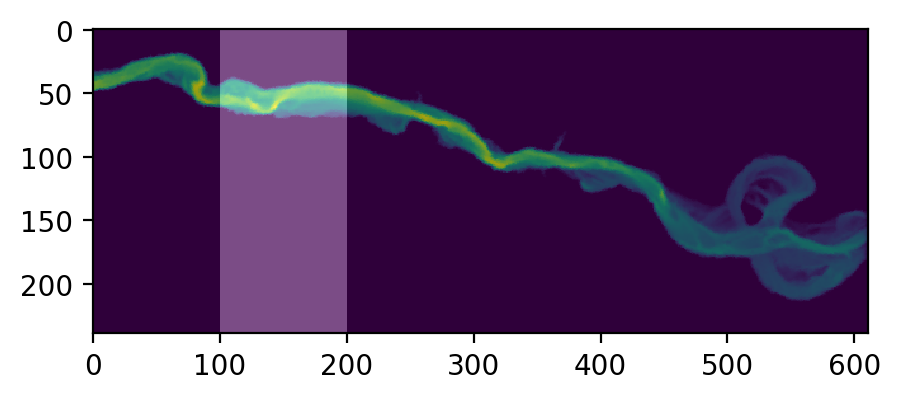

In [13]:
# Create the array
regions = np.zeros_like(depth, dtype='int')
regions[:,100:200] = 1 # Include anywhere above sea level

# Visualize the region
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(depth)
plt.imshow(regions, cmap='bone', alpha=0.3)

Then compute. `exposure_time()` outputs a list of exposure times by particle index, and `plot_exposure_time()` will use those values to generate plots of the cumulative and differential forms of the ETD (i.e. the CDF and PDF, respectively).

100%|#################################################################################| 50/50 [00:00<00:00, 769.23it/s]


[147.29066796706636,
 151.80246531555946,
 164.37189927914852,
 169.31411522517814,
 168.39236140703522,
 167.73048261517746,
 163.80821316079567,
 153.0562796291658,
 193.66266442932184,
 157.6849354704393,
 181.88829014547227,
 174.43609731279938,
 209.18375123103672,
 252.5047056205399,
 154.64454680029374,
 194.5383167482415,
 198.69677521708547,
 148.44419298475492,
 151.3999268393884,
 198.43401074464947,
 196.16317504958124,
 155.5599718268985,
 155.2284610591312,
 153.31252245214824,
 149.33804407624524,
 210.3160452399242,
 155.0323048936441,
 161.61305129395325,
 207.81322588763277,
 194.09268836043066,
 146.3930681814939,
 176.84120568807114,
 166.97067861175242,
 166.3085676229869,
 156.09070007328768,
 159.73591071563914,
 155.70524408150527,
 160.1713998219152,
 149.5006382277346,
 168.507503082072,
 183.55781647970335,
 209.1298488038976,
 180.0508649547589,
 166.12481228675045,
 155.68371093864718,
 155.37737674480337,
 181.97504650908482,
 153.88053550616502,
 160.1997

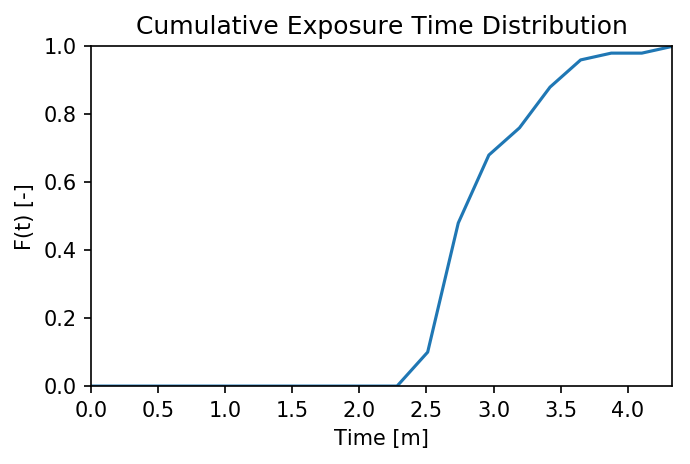

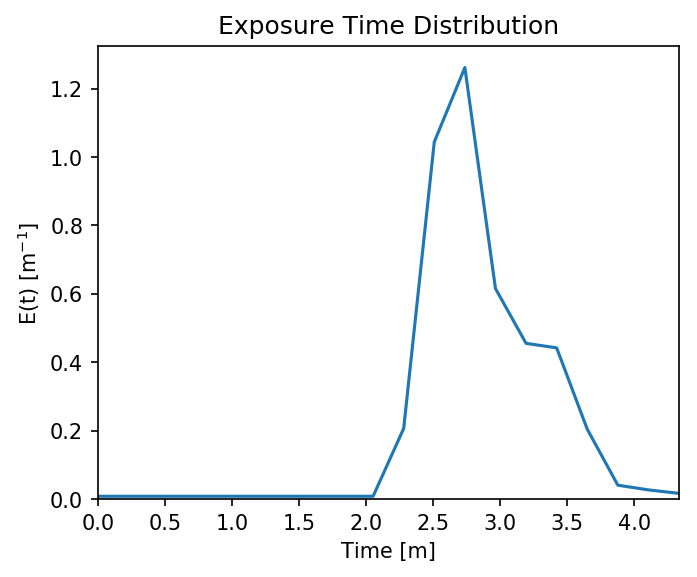

In [14]:
# Measure exposure times
exposure_times = pt.exposure_time(walk_data, 
                                  regions)
# Then generate plots and save data
routines.plot_exposure_time(walk_data,
                            exposure_times,
                            'unstructured_grid_anuga/figs', 
                            timedelta = 60, nbins=20)
# Changing 'timedelta' will change the units of the time-axis. 
# Units are seconds, so 60 will plot by minute. 
# Because we are using fewer particles than ideal, smooth the plots with small 'nbins'

**Note:** If any particles are still in the ROI at the end of their travel history, they are excluded from plots. These particles are not done being "exposed," so we need to run more iterations in order to capture the tail of the distribution. 